In [ ]:
library(repr) ; options(repr.plot.width = 5, repr.plot.height = 6) # Change plot sizes (in cm)

# Bootstrapping using rTPC package

## Introduction
In this Chapter we will work through an example of model fitting using the rTPC package in R. This references the previous chapters' work, especially [Model Fitting the Bayesian way](https://www.youtube.com/watch?v=dQw4w9WgXcQ).

Lets start with the requirements!

In [2]:
require('ggplot2')
require('nls.multstart')
require('broom')
require('tidyverse')
require('rTPC')
require('dplyr')
require('data.table')
require('car')
require('boot')
require('patchwork')
require('minpack.lm')
require("tidyr")
require('purrr')
# update.packages(ask = FALSE)

rm(list=ls())
graphics.off()
setwd("/home/primuser/Documents/VByte/VecMismatchPaper1/code/")

Loading required package: ggplot2

Loading required package: nls.multstart

Loading required package: broom

Loading required package: tidyverse

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ tibble  3.1.2     ✔ dplyr   1.0.6
✔ tidyr   1.1.3     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.1
✔ purrr   0.3.4     

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Loading required package: rTPC

Loading required package: data.table


Attaching package: ‘data.table’


The following objects are masked from ‘package:dplyr’:

    between, first, last


The following object is masked from ‘package:purrr’:

    transpose


Loading required package: car

Loading required package: carData


Attaching package: ‘car’


The following object is masked from ‘package:dplyr’:

    recode


The following object is masked from ‘package:purrr’:

    some



Now that we have the background requirements going, we can start using the rTPC package. Lets look through the different models available!

In [2]:
#take a look at the different models available
get_model_names()

[1] "beta_2012"             "boatman_2017"          "briere2_1999"         
 [4] "delong_2017"           "flinn_1991"            "gaussian_1987"        
 [7] "hinshelwood_1947"      "joehnk_2008"           "johnsonlewin_1946"    
[10] "kamykowski_1985"       "lactin2_1995"          "modifiedgaussian_2006"
[13] "oneill_1972"           "pawar_2018"            "quadratic_2008"       
[16] "ratkowsky_1983"        "rezende_2019"          "sharpeschoolfull_1981"
[19] "sharpeschoolhigh_1981" "sharpeschoollow_1981"  "spain_1982"           
[22] "thomas_2012"           "thomas_2017"           "weibull_1995"

There are 24 models to choose from. For our purposes in this chapter we will be using the sharpesschoolhigh_1981 model. More information on the model can be found [here](https://padpadpadpad.github.io/rTPC/reference/sharpeschoolhigh_1981.html).

From here lets load in our data from the overall repository. This will be called '../data/Final_Traitofinterest.csv'.

In [3]:
#read in the trait data
final_trait_data <- read.csv('../data/Final_Traitofinterest.csv')

Lets reduce this to a single trait. This data comes from the [VectorBiTE database](https://legacy.vectorbyte.org/) and so has unique IDs. We will use this to get our species and trait of interest isolated from the larger dataset. In this example we will be looking at Development Rate across temperatures for Aedes albopictus, which we can find an example of in csm7I.

In [4]:
df1 <- final_trait_data %>%
  dplyr::select('originalid', 'originaltraitname', 'originaltraitunit', 'originaltraitvalue', 'interactor1', 'ambienttemp', 'citation')
#filter to single species and trait
df2 <- dplyr::filter(df1, originalid == 'csm7I')

Now lets visualize our data in ggplot.

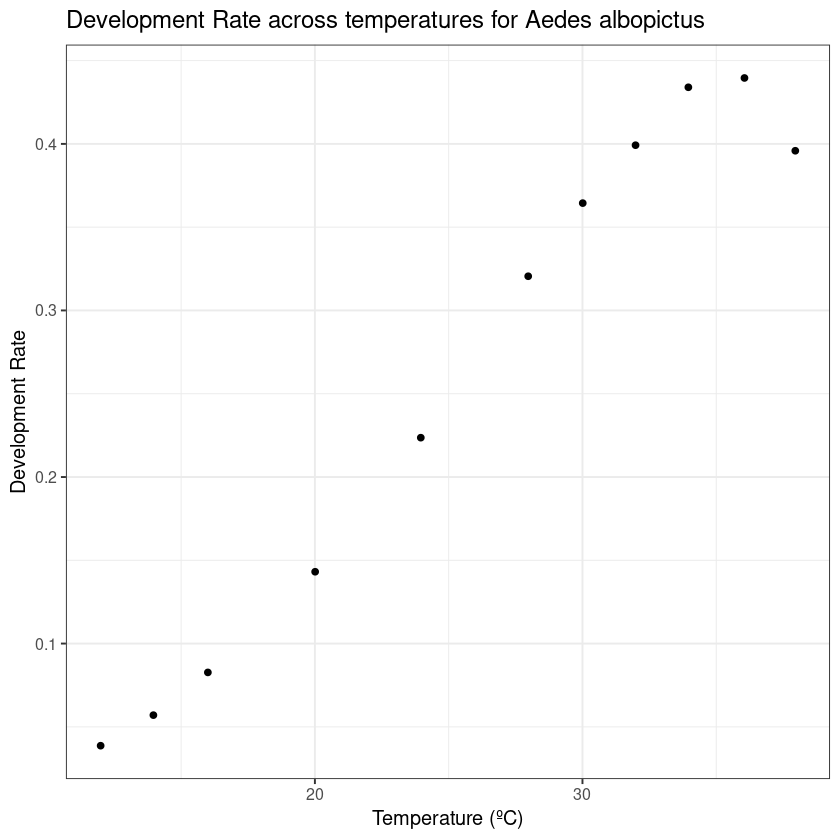

In [5]:
#visualize
ggplot(df2, aes(ambienttemp, originaltraitvalue))+
  geom_point()+
  theme_bw(base_size = 12) +
  labs(x = 'Temperature (ºC)',
       y = 'Development Rate',
       title = 'Development Rate across temperatures for Aedes albopictus')

We will need to write which model we are using (sharpschoolhigh_1981). From here we can actually build our fit. We will use ''nls_multstart'' to automatically find our starting values. This lets us skip the [starting value problem](https://mhasoba.github.io/TheMulQuaBio/notebooks/20-ModelFitting-NLLS.html#the-starting-values-problem). From here we build our predicted line.

In [6]:
# choose model
mod = 'sharpschoolhigh_1981'
d<- df2 %>%
  rename(temp = ambienttemp,
         rate = originaltraitvalue)

In [7]:
# fit Sharpe-Schoolfield model
d_fit <- nest(d, data = c(temp, rate)) %>%
  mutate(sharpeschoolhigh = map(data, ~nls_multstart(rate~sharpeschoolhigh_1981(temp = temp, r_tref,e,eh,th, tref = 15),
                                                     data = .x,
                                                     iter = c(3,3,3,3),
                                                     start_lower = get_start_vals(.x$temp, .x$rate, model_name = 'sharpeschoolhigh_1981') - 10,
                                                     start_upper = get_start_vals(.x$temp, .x$rate, model_name = 'sharpeschoolhigh_1981') + 10,
                                                     lower = get_lower_lims(.x$temp, .x$rate, model_name = 'sharpeschoolhigh_1981'),
                                                     upper = get_upper_lims(.x$temp, .x$rate, model_name = 'sharpeschoolhigh_1981'),
                                                     supp_errors = 'Y',
                                                     convergence_count = FALSE)),
         
         # create new temperature data
         new_data = map(data, ~tibble(temp = seq(min(.x$temp), max(.x$temp), length.out = 100))),
         # predict over that data,
         preds =  map2(sharpeschoolhigh, new_data, ~augment(.x, newdata = .y)))

In [8]:
# unnest predictions
d_preds <- select(d_fit, preds) %>%
  unnest(preds)

Lets visualize the line:

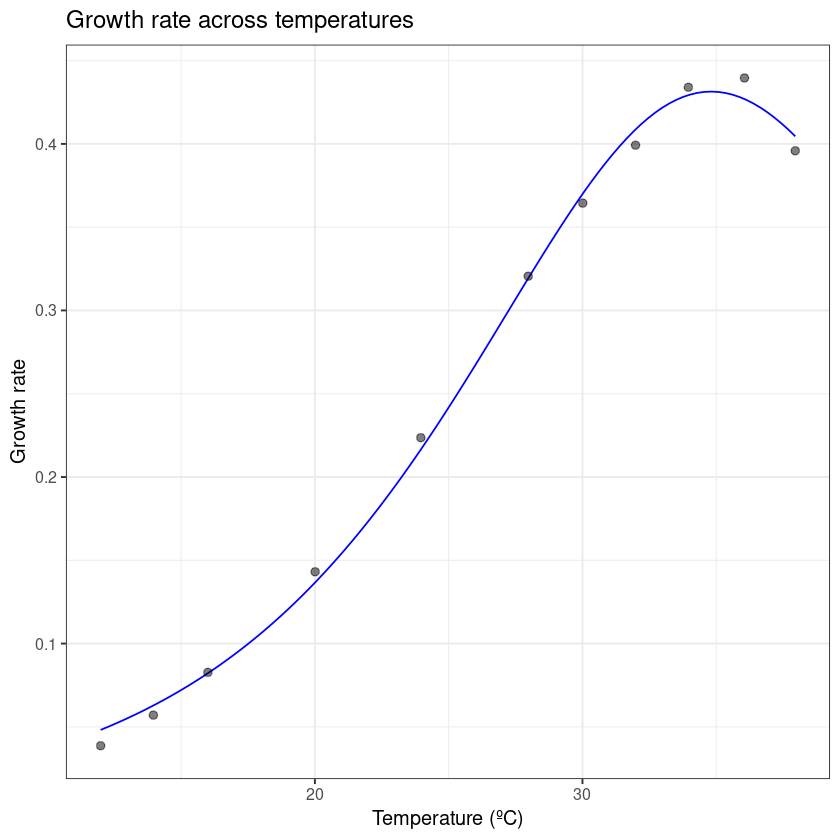

In [9]:
# plot data and predictions
ggplot() +
  geom_line(aes(temp, .fitted), d_preds, col = 'blue') +
  geom_point(aes(temp, rate), d, size = 2, alpha = 0.5) +
  theme_bw(base_size = 12) +
  labs(x = 'Temperature (ºC)',
       y = 'Growth rate',
       title = 'Growth rate across temperatures')

This looks like a good fit! We can start exploring using bootstrapping. Lets start with refitting the model using nlsLM.

In [10]:
# refit model using nlsLM
fit_nlsLM <- minpack.lm::nlsLM(rate~sharpeschoolhigh_1981(temp = temp, r_tref,e,eh,th, tref = 15),
                               data = d,
                               start = coef(d_fit$sharpeschoolhigh[[1]]),
                               lower = get_lower_lims(d$temp, d$rate, model_name = 'sharpeschoolhigh_1981'),
                               upper = get_upper_lims(d$temp, d$rate, model_name = 'sharpeschoolhigh_1981'),
                               weights = rep(1, times = nrow(d)))

Now we can actually bootstrap.

In [11]:
# bootstrap using case resampling
boot1 <- Boot(fit_nlsLM, method = 'case')

Warning message in nls.lm(par = start, fn = FCT, jac = jac, control = control, lower = lower, :
“lmdif: info = -1. Number of iterations has reached `maxiter' == 50.
”
Warning message in nls.lm(par = start, fn = FCT, jac = jac, control = control, lower = lower, :
“lmdif: info = -1. Number of iterations has reached `maxiter' == 50.
”


It is a good idea to explore the data again now.

In [12]:
# look at the data
head(boot1$t)

r_tref,e,eh,th
0.07332351,1.1452808,1.435608,30.20537
0.07562925,0.8356209,2.415334,37.12038
0.07825423,1.3896922,1.356699,24.89526
0.07364820,1.0873132,1.480281,31.50611
0.06964343,1.0656042,1.789697,32.68795
0.07241913,1.0634804,1.666116,32.08294


Warning message in norm.inter(t, adj.alpha):
“extreme order statistics used as endpoints”
Warning message in norm.inter(t, adj.alpha):
“extreme order statistics used as endpoints”
Warning message in norm.inter(t, adj.alpha):
“extreme order statistics used as endpoints”


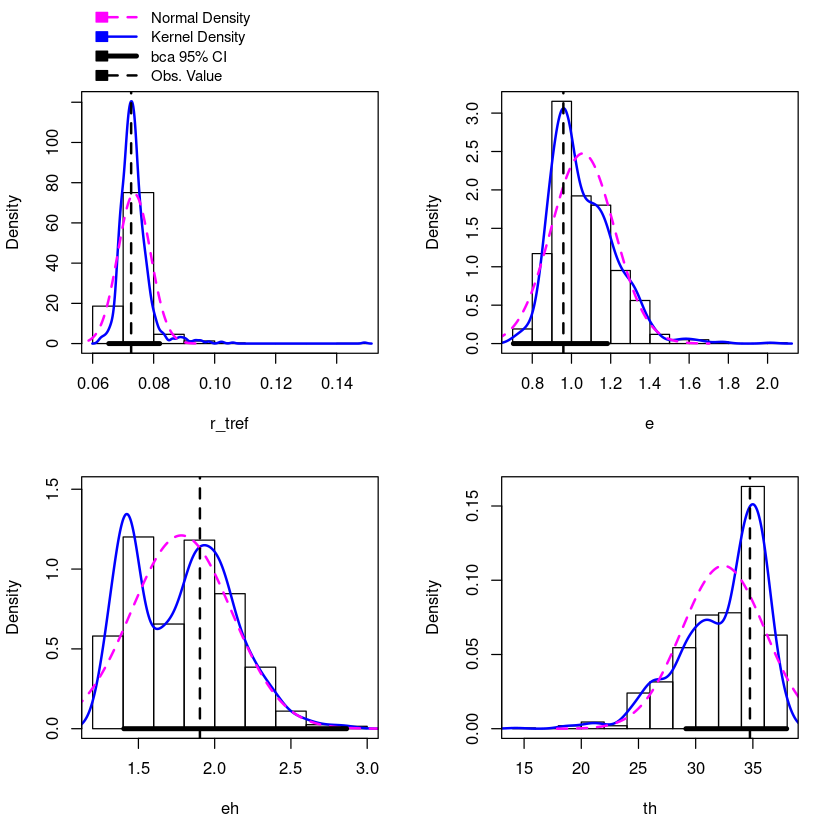

In [13]:
hist(boot1, layout = c(2,2))

Now we use the bootstrapped model to build predictions which we can explore visually.

In [14]:
# create predictions of each bootstrapped model
boot1_preds <- boot1$t %>%
  as.data.frame() %>%
  drop_na() %>%
  mutate(iter = 1:n()) %>%
  group_by_all() %>%
  do(data.frame(temp = seq(min(d$temp), max(d$temp), length.out = 100))) %>%
  ungroup() %>%
  mutate(pred = sharpeschoolhigh_1981(temp, r_tref, e, eh, th, tref = 15))

In [15]:
# calculate bootstrapped confidence intervals
boot1_conf_preds <- group_by(boot1_preds, temp) %>%
  summarise(conf_lower = quantile(pred, 0.025),
            conf_upper = quantile(pred, 0.975)) %>%
  ungroup()

In [16]:
# plot bootstrapped CIs
p1 <- ggplot() +
  geom_line(aes(temp, .fitted), d_preds, col = 'blue') +
  geom_ribbon(aes(temp, ymin = conf_lower, ymax = conf_upper), boot1_conf_preds, fill = 'blue', alpha = 0.3) +
  geom_point(aes(temp, rate), d, size = 2, alpha = 0.5) +
  theme_bw(base_size = 12) +
  labs(x = 'Temperature (ºC)',
       y = 'Growth rate',
       title = 'Growth rate across temperatures')

# plot bootstrapped predictions
p2 <- ggplot() +
  geom_line(aes(temp, .fitted), d_preds, col = 'blue') +
  geom_line(aes(temp, pred, group = iter), boot1_preds, col = 'blue', alpha = 0.007) +
  geom_point(aes(temp, rate), d, size = 2, alpha = 0.5) +
  theme_bw(base_size = 12) +
  labs(x = 'Temperature (ºC)',
       y = 'Growth rate',
       title = 'Growth rate across temperatures')

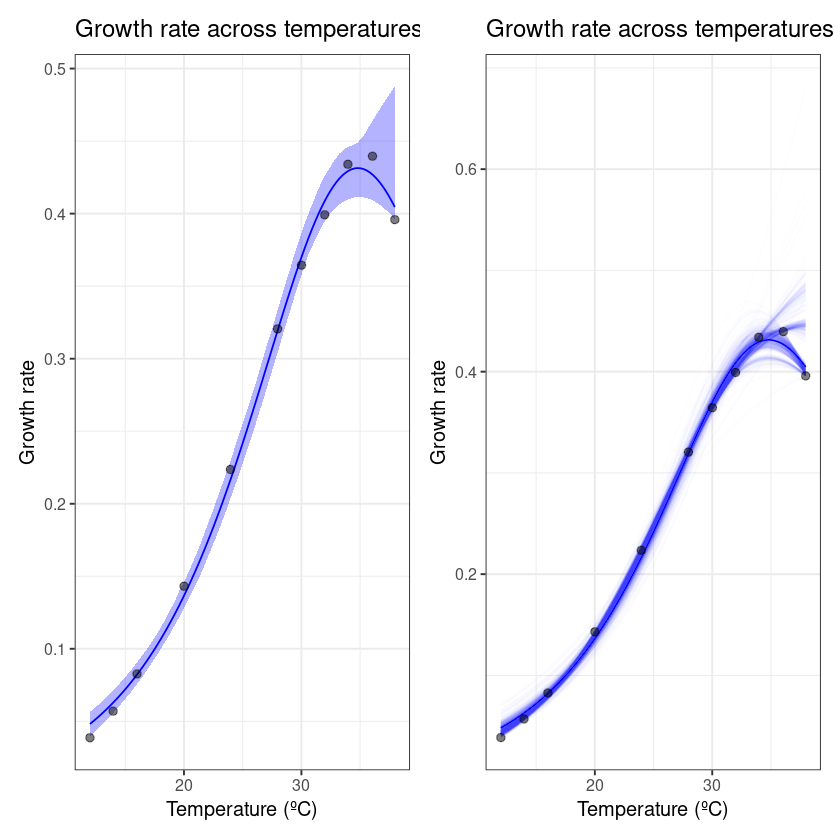

In [17]:
p1 + p2

We can see here that when we bootstrap this data, the fit is not as good as we would expect from the initial exploration. We do not necessarily get a good thermal optima from this data. However, this does show how to use this function in the future. Please see Daniel Padfields [git](https://padpadpadpad.github.io/rTPC/articles/rTPC.html) for more information on using the rTPC package.

# Please go to the [landing page](https://www.youtube.com/watch?v=YddwkMJG1Jo) and proceed on to the next stage of the training!